# Explorations and tests with the heavier data-star

- dst28gm06n052

st28gm06n052_186.sav

st28gm06n052_190.sav

st28gm06n052_198.sav

In [6]:
# Check stellar props
from scipy.io.idl import readsav
import numpy as np
import analyze_co5bold_functions as a5d

teststar = readsav('../co5bold_data/dst28gm06n052/st28gm06n052_186.sav')
teststar = teststar['ful']

# Star's props
#print(teststar['PAR'][0][0][2])

#Grid's props
# Size of grid
#print(np.shape(teststar['EOS'][0][0][0]))

# Number of cells along each axis
print(teststar['Z'][0][0][38])
print(teststar['Z'][0][0][41])
print(teststar['Z'][0][0][42])
print(np.shape(teststar['Z'][0][0][43]))

# Minimum cellsize:
#AUcm = 1.49598e13 # cm
#c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
#    savpath='../co5bold_data/dst28gm06n052/st28gm06n052_186.sav'
#)

#print(f'Minimum cell: {cellsize/AUcm} AU')
#print(f'Total size of grid: {(np.max(cellcourners)-np.min(cellcourners))/AUcm} AU')



# '3D dusty AGB star model: 1 M_Sun, 355 R_Sun, L=7000 L_Sun'
# > Teff = 2800K



b'erg/g'
b'1/cm^3'
b'n_forsterite'
(679, 679, 679)


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


12.215648112309523


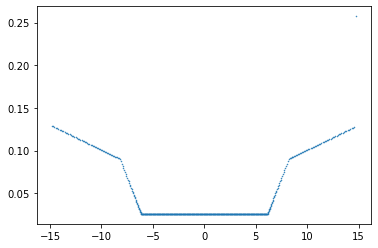

In [28]:
import matplotlib.pyplot as plt
import analyze_co5bold_functions as a5d
import numpy as np

AUcm = 1.49598e13 # cm
c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
    savpath='../co5bold_data/dst28gm06n052/st28gm06n052_186.sav'
)
Ncourners = cellcourners[:,0].size - 1
cellsizes = np.zeros(Ncourners)
cellcoords = np.zeros(Ncourners)

for nn in range(Ncourners):
    cellsizes[nn] = (cellcourners[nn+1,0] - cellcourners[nn,0])/AUcm
    cellcoords[nn] = (0.5*(cellcourners[nn+1,0] + cellcourners[nn,0]))/AUcm

plt.plot(cellcoords,cellsizes,'.',markersize=1)

# Size of the inner fine-resolution space:
print(
    cellcoords[np.where(cellsizes == cellsizes.min())[0][-1]] - cellcoords[np.where(cellsizes == cellsizes.min())[0][0]]
)

In [17]:
# Create grid
import create_r3d_functions as c3d

# Smallest c5d cells are 0.026 AU
# Radius of star: 1.651AU (355 Rsun)
# Settings for the grid
AUcm = 1.49598e13 # cm
r3dedge = 29.796 * AUcm # Size of whole grid
basecell = 0.03*AUcm * 2**4 # Size of base cell (smallest cell is 0.03 AU)
nxyz = r3dedge/basecell
refinementlist_au = [9.5, 5.5, 3.5, 2.5]
refinementlist = [refs*AUcm for refs in refinementlist_au]

c3d.create_grid(
    gridedge=r3dedge/AUcm, 
    nxyz=nxyz, 
    refinementlist=refinementlist_au, 
    inrefine=0.13, 
    savegrid=True
)

# If I didn't have it already, create wavelength-grid here also!

Creating amr_grid with octree refinement.
Final length of total side of whole grid: 29.759999999999998 AU
Number of base cells along one side of the grid: 62
Distances to outer refinement limits from centrum: [9.5, 5.5, 3.5, 2.5] AU
Distances to inner refinement limits from centrum: [0.325, 0.65, 0.9750000000000001, 1.3] AU
Number refinements: 4
Size of base cell: 0.48 AU
Child cell size 1: 0.24 AU
Child cell size 2: 0.12 AU
Child cell size 3: 0.06 AU
Child cell size 4: 0.03 AU
Writing amr_grid.inp
Writing grid_distances.csv and grid_cellsizes.csv
(Not necessary for Radmc3d, but useful for pre/portprocessing of your model. They have the same order as dust_densities.inp)
Writing grid_info.txt
Create grid:
    amr_grid.inp
     grid_info.txt
    grid_distances.csv
    grid_cellsizes.csv
DONE



## Analyze input data

In [ ]:
# Plot densities as func of radius of all star-species
import analyze_r3d_functions as a3d

a3d.plot_alldensity_radius(
    path='../r3dresults/st28gm06n052/9species_186/'
)

In [ ]:
# Plot temperatures as func of radius of all star-species
import analyze_r3d_functions as a3d

a3d.plot_alltemperature_radius(
    path='../r3dresults/st28gm06n052/9species_186/'
)

In [ ]:
# Plot c5d's kappa in r3d-grid
import analyze_co5bold_functions as a5d

a5d.plot_opakapparadius(
    path='../r3dresults/st28gm06n052/9species_186/'
)


In [ ]:
# Plot all star-kappa as func of wavelength
import analyze_r3d_functions as a3d

a3d.plot_allkappa(
    path='../r3dresults/st28gm06n052/9species_186/'
)

## Analyze images and SED

In [ ]:
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/9species_186/'

imagewaves = [1,10,1000]
images = [f'image_{imagewave}um.out' for imagewave in imagewaves]

testflux = a3d.plot_images(
    path=path,
    images=images,
    distance=1
)

maxflux,maxwave = a3d.plot_sed(path=f'{path}spectrum.out')

# Print luminosity in Lsols
# Wien's displacement law: freqmax = kb/h*T * 2.821439[..]
print(f"{a3d.compute_luminosity(path=f'{path}spectrum.out')/3.828e26} Lsol")
print(f'Max flux: {maxflux} Jy, at {maxwave} um.')
print(f'BB-temperature: {2.998e8/(5.879e10 * maxwave*1e-6)} K')

plt.plot(imagewaves,testflux,'r*')


# Test final create-stars-script

In [1]:
# With smoothing

import create_r3d_functions as c3d
import analyze_co5bold_functions as a5d
import analyze_r3d_functions as a3d
import os

# Some definitions
AUcm = 1.49598e13 # cm
modelname = 'st28gm06n052'
path = f'../r3dresults/{modelname}/'
phases = [186,190,198]


# Extract c5d grid size and star size in cm
c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)
Mstar,Rstar,Lstar = a5d.load_star_information(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)


# Create spatial grid

# Settings for the grid
r3dedge = 2 * cellcourners.max() # Size of whole grid
basecell = cellsize*1.001 * 2**4 # Size of base cells (based on smallest cells and 4 refinements, make it slightly larger to be safe)
nxyz = r3dedge/basecell # Number of base cells per size

# Refinements based on stellar radius
refinementlist_au = [
    3.0*Rstar/AUcm,
    2.5*Rstar/AUcm,
    2.0*Rstar/AUcm,
    1.5*Rstar/AUcm
]

# Inner refinements up to 0.9 Rstar
inrefine_au = 0.9*Rstar/AUcm

# Create grid
c3d.create_grid(
    gridedge = r3dedge/AUcm, 
    nxyz = nxyz, 
    refinementlist = refinementlist_au, 
    inrefine = inrefine_au, 
    savegrid=True
)

# Move grid files to correct folder
os.system(
    f'mv ../amr_grid.inp {path}'
)
os.system(
    f'mv ../grid_info.txt {path}'
)
os.system(
    f'mv ../grid_distances.csv {path}'
)
os.system(
    f'mv ../grid_cellsizes.csv {path}'
)

# Create wavelength grid
wavelengths = c3d.create_wavelength(
    wavelengthstart = 0.1,
    wavelengthend = 1000.0,
    nwave = 100,
    logscale = 'y'
)

# Move wavelengthgrid to data-folder
os.system(
    f'mv ../wavelength_micron.inp {path}'
)

# List for stellar radii per phase
starradii = []

for phase in phases:
    # And copy wavelength-grid to each phase-folder
    os.system(
        f'cp {path}wavelength_micron.inp {path}{phase}/'
    )

    # Extract star's radius for each phase
    Mstar,Rstar,Lstar = a5d.load_star_information(
        savpath = f'../co5bold_data/d{modelname}/{modelname}_{phase}.sav',
        printoutput = 'n'
    )
    starradii.append(Rstar)


# Extract griddistances
griddistances = a3d.load_griddistances(
    gridpath= f'{path}grid_distances.csv',
    amrpath= f'{path}amr_grid.inp'
)[:,0]


# Create all r3d-data from c5d-data
a5d.create_stars(
    modelnames = [modelname],
    phases = phases
)


# Remove negative spikes in opacity and density to correct final luminosity
a5d.smooth_stellardata(
    path = path,
    phases = phases,
    starradii=starradii,
    griddistances=griddistances,
)


# Create radmc3d-run scripts
c3d.write_r3d_runscripts(
    path = path,
    phase_list = phases,
    sed_inclination_list = [0,90,180,270],
    image_wavelength_list = [1,10,100],
    image_inclination_list = [0,90,180,270],
    image_sizeau = r3dedge/AUcm,
    image_npix = 256,
)



print('All done')

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Stellar info: '3D dusty AGB star model: 1 M_Sun, 355 R_Sun, L=7000 L_Sun'
Creating amr_grid with octree refinement.
Final length of total side of whole grid: 29.780836060395945 AU
Number of base cells along one side of the grid: 72
Distances to outer refinement limits from centrum: [4.951319536357438, 4.126099613631198, 3.3008796909049587, 2.475659768178719] AU
Distances to inner refinement limits from centrum: [0.3713489652268079, 0.7426979304536158, 1.1140468956804235, 1.4853958609072315] AU
Number refinements: 4
Size of base cell: 0.4136227230610557 AU
Child cell size 1: 0.20681136153052784 AU
Child cell size 2: 0.10340568076526392 AU
Child cell size 3: 0.05170284038263196 AU
Child cell size 4: 0.02585142019131598 AU
Writing amr_grid.inp
Writing grid_distances.csv and grid_cellsizes.csv
(Not necessary for Radmc3d, but useful for pre/portprocessing of your model. They have the same order as dust_densities.inp)
Writing grid_info.txt
Create grid:
    amr_grid.inp
    grid_info.txt
    

In [1]:
# Manual change run scripts afterwards

import create_r3d_functions as c3d
import analyze_co5bold_functions as a5d

AUcm = 1.49598e13 # cm
modelname = 'st28gm06n052'
path = f'../r3dresults/{modelname}/'
phases = [186,190,198]


c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)

# Settings for the grid
r3dedge = 2 * cellcourners.max() # Size of whole grid

# Create radmc3d-run scripts
c3d.write_r3d_runscripts(
    path = path,
    phase_list = phases,
    sed_inclination_list = [0,90,180,270],
    image_wavelength_list = [1,10,100],
    image_inclination_list = [0,90,180,270],
    image_sizeau = r3dedge/AUcm,
    image_npix = 256,
)


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Finished writing run-r3d-scripts:
    r3doutput_[PHASE].txt
    runcommand[PHASE].sh
    runcommand_main.sh



/tmp/ipykernel_26571/778947742.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


Lum (i = 0 deg): 5206.456654280256
Lum (i = 90 deg): 6487.268386139034
Lum (i = 180 deg): 7847.574604403732
Lum (i = 270 deg): 8308.462940410753
SED-Luminosity 186: 6962.440646308444 Lsol
BB-temperature 186: 2366.981344305215 K
Lum (i = 0 deg): 7179.914508747603
Lum (i = 90 deg): 6659.02673035107
Lum (i = 180 deg): 9186.486740931176
Lum (i = 270 deg): 8698.921673895798
SED-Luminosity 190: 7931.087413481413 Lsol
BB-temperature 190: 2366.981344305215 K
Lum (i = 0 deg): 8125.573297304738
Lum (i = 90 deg): 7001.353763832313
Lum (i = 180 deg): 8265.813187909982
Lum (i = 270 deg): 7905.813865192404
SED-Luminosity 198: 7824.638528559858 Lsol
BB-temperature 198: 2366.981344305215 K


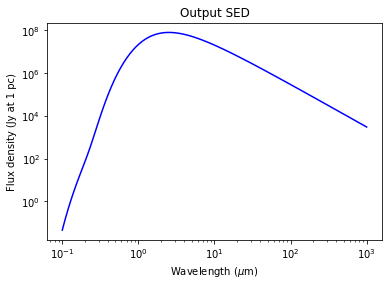

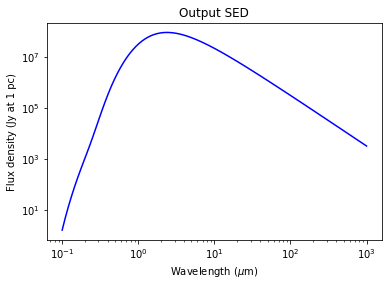

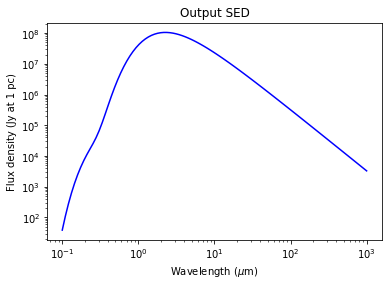

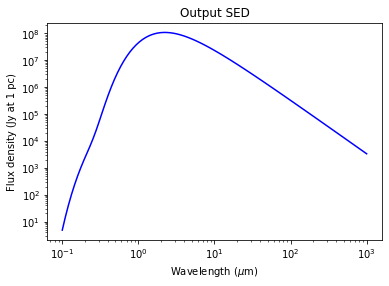

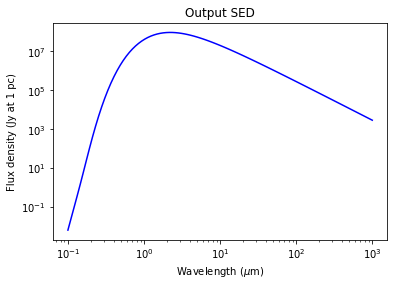

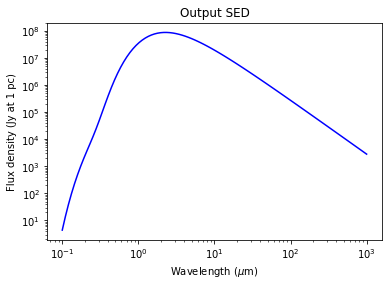

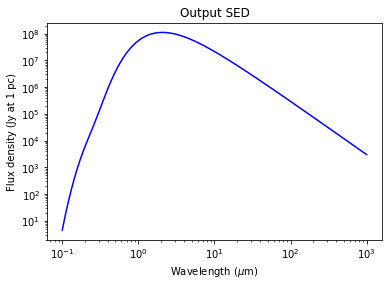

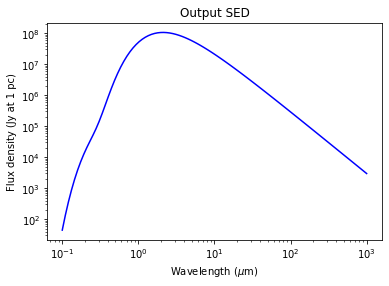

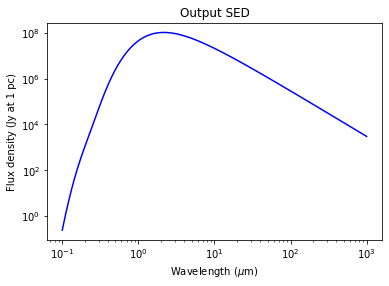

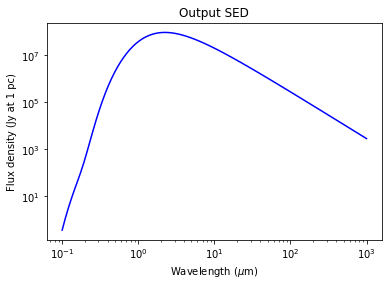

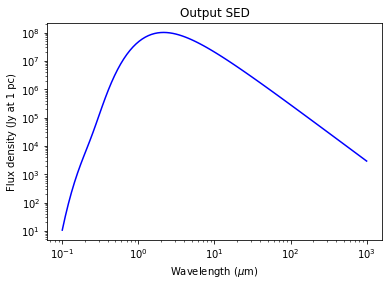

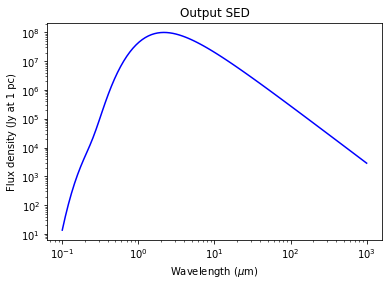

In [1]:
# Plot SEDs

import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/'
phases = [186,190,198]
sedincls = [0,90,180,270]

for phase in phases:

    lumtot = 0

    # Plot SEDs
    for sedincl in sedincls:
        fig,ax,maxflux,maxwave = a3d.plot_sed(
            path=f'{path}{phase}/spectrum_i{sedincl}.out'
        )
        fig.show();

        # Compute luminosity
        lum = a3d.compute_sed_luminosity(
            path=f'{path}{phase}/spectrum_i{sedincl}.out'
        )
        lumtot += lum
        print(f'Lum (i = {sedincl} deg): {lum/3.828e26}')

    lumtot /= len(sedincls)*3.828e26

    # Printouts
    print(f"SED-Luminosity {phase}: {lumtot} Lsol")
    print(f'BB-temperature {phase}: {2.998e8/(5.879e10 * maxwave*1e-6)} K')


['image_i0_1um.out']


/tmp/ipykernel_52101/3974580564.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


['image_i0_1um.out']
['image_i0_1um.out']


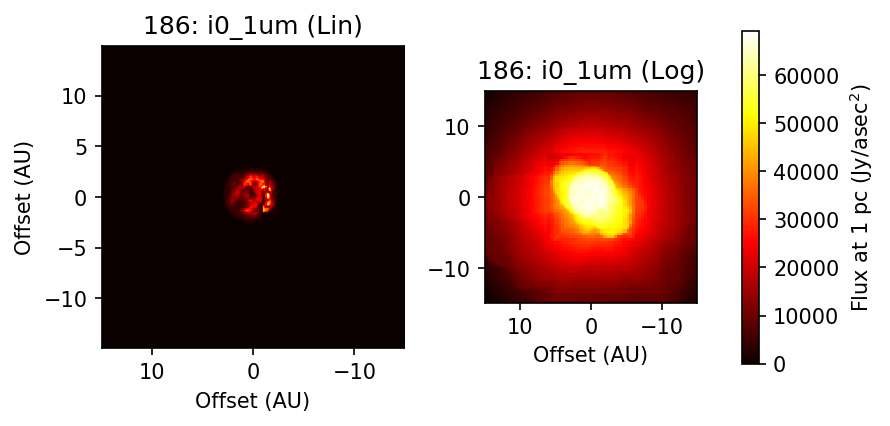

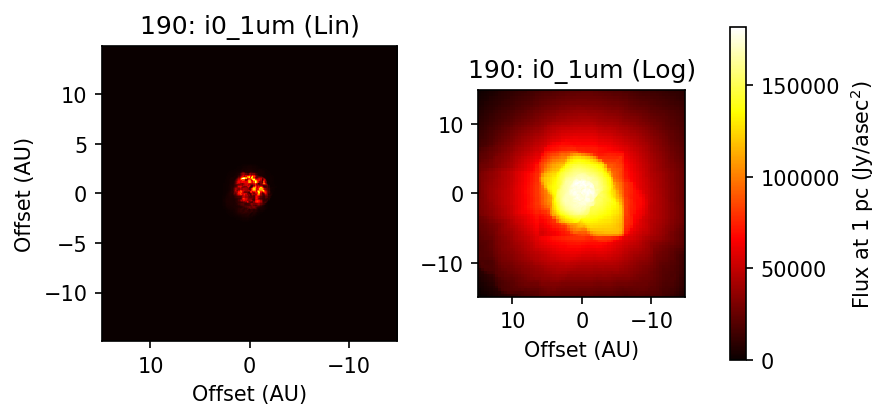

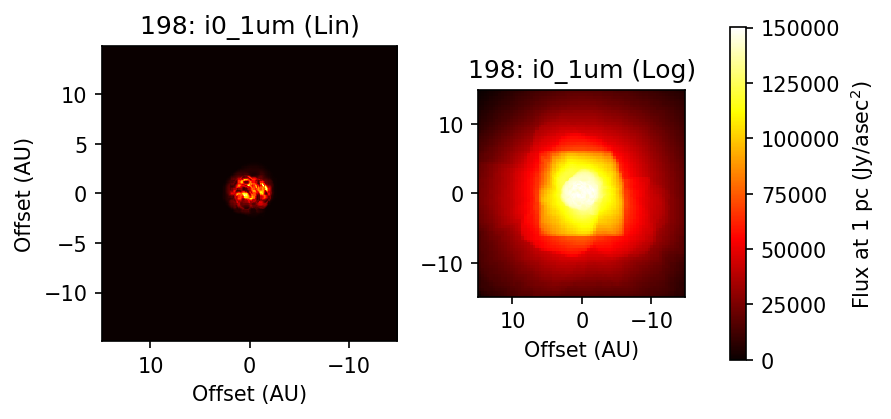

In [3]:
# Plot results

import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/'
phases = [186,190,198]
#imagewaves = [1,10,100]
#imageincls = [0,90,180,270]

#phases = [186]
imagewaves = [1]
imageincls = [0]

# List of image file names:
# Yes, I could use list compr, but this is easier to read
images = []
for imageincl in imageincls:
    for imagewave in imagewaves:
        images.append(f'image_i{imageincl}_{imagewave}um.out')


for phase in phases:
    # Plot images
    fig,ax,testflux = a3d.plot_images(
        path = f'{path}{phase}/',
        images = images,
        distance = 1
    )
    print(images)

    fig.tight_layout()
    fig.show()



# Find and save dust data

In [2]:
# Notebook for exploring the data insize the sav-file

import numpy as np
from scipy.io.idl import readsav


teststar = readsav('../co5bold_data/dst28gm06n052/st28gm06n052_186.sav')
teststar = teststar['ful']

# Dict-columns
#print(teststar.dtype.names)
#print('\n\n')

# Print some contents of your chosing
densitytest = np.array(teststar['Z'][0][0][40+3*0])

print(type(teststar['Z'][0][0][40+3*0]))
print(densitytest.shape)
print(type(densitytest))


with open('../c5ddust_density.npy', 'wb') as fgas:
    np.save(
        fgas, densitytest,
        allow_pickle=True, 
        fix_imports=False
    )


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


<class 'numpy.ndarray'>
(679, 679, 679)
<class 'numpy.ndarray'>


In [1]:
# Test create dust files
import analyze_co5bold_functions as a5d
a5d.create_dustfiles(
    amrpath='../r3dresults/st28gm06n052/186/amr_grid.inp',
    gridpath='../r3dresults/st28gm06n052/grid_distances.csv',
    sizepath='../r3dresults/st28gm06n052/grid_cellsizes.csv',
)

# took 57min

Loading R3D grid
Loading C5D grid properties


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Loaded grain species: ['forsterite']
Loading grain sizes
Availble grain sizez are (um): [0.04725051 0.14162608 0.23600165 0.33037723 0.4247528  0.51912837
 0.61350395 0.70787952 0.80225509 0.89663067]

Loading CO5BOLD densities and temperatures

Translating C5D dust data to R3D dust data (186)
Writing dust specie number 1:
    forsterite
    Grain size: 0.04725050785375921 um
    Monomer mass: [2.3362e-22] g
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
Writing dust specie number 1:
    forsterite
    Grain size: 0.14162608092169926 um
    Monomer mass: [2.3362e-22] g
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
Writing dust specie number 1:
    forsterite
    Grain size: 0.23600165398963932 um
    Monomer mass: [2.3362e-22] g
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
Writing dust specie number 1:
    forsterite
   

### Extract grain sizes tests

In [2]:
# Load gas and dust monomer densities
import analyze_co5bold_functions as a5d

gas_densities, dust_densities = a5d.load_dustgas_densities(
    savpath = '../co5bold_data/dst28gm06n052/st28gm06n052_186.sav',
    nspecies = 0
)

# write function that extracts these two densities only instead

# TODO
# write down the time it took for this!
# 56 min

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


In [ ]:
import numpy as np

Amon = 2.3362e-22 # g
rhomon = 3.27 # g cm-3
nHnd = 3e-16
mH = 1.6726e-27 # g
epsilonHe = 0.1

grainsize_constants = (3/(4*np.pi) * Amon/rhomon * nHnd * mH * (1+epsilonHe))**(1/3)

print(grainsize_constants)

In [2]:
import analyze_co5bold_functions as a5d
# Need to load npy-files first
a5d.load_c5dheavydata(
    savpath = '../co5bold_data/dst28gm06n052/st28gm06n052_198.sav',
    gas_density=False,
    dust_density=False,
    gas_opacity=False,
    temperature=True
)

Loading from CO5BOLD for phase 198
Temperatures
load_c5dheavydata:
    c5dgas_density_198.npy
    c5ddust_density_198.npy
    c5dgas_opacity_198.npy
    c5d_temperature_198.npy
DONE



In [1]:

a5d.extract_grainsizes(
    savpath = '../co5bold_data/dst28gm06n052/st28gm06n052_198.sav'
)



Loading R3D grid
Loading C5D grid properties


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Computing grain sizes and saving them in R3D-grid (186)
Loading gas and monomer densities from CO5BOLD-files (186)
(679, 679, 679)
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
C5D grain sizes:
    grain_sizes_186.dat
DONE



In [3]:
import analyze_co5bold_functions as a5d
a5d.bin_grainsizes(
    grainsizepath='../grain_sizes_198.dat',
    phase='198',
    nbins=10,
    lin='y'
)


a5d.bin_grainsizes():
    grain_sizes_binned_198.dat
DONE



/tmp/ipykernel_26110/3868492688.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


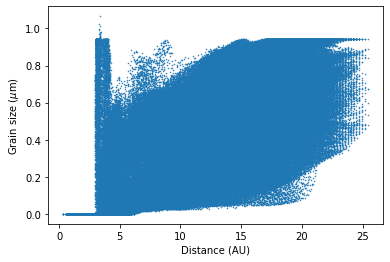

In [2]:
import analyze_r3d_functions as a3d
fig, ax = a3d.plot_grainsize_radius(
    grainsizepath='../grain_sizes_186.dat'
)
fig.show()


/tmp/ipykernel_26924/1926302987.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


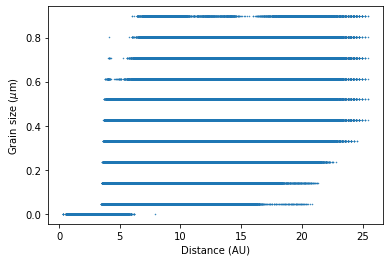

In [3]:
import analyze_r3d_functions as a3d
fig, ax = a3d.plot_grainsize_radius(
    grainsizepath='../grain_sizes_binned_198.dat'
)
fig.show()

/tmp/ipykernel_43690/72070863.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_43690/72070863.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_43690/72070863.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


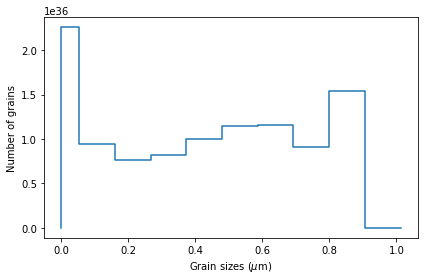

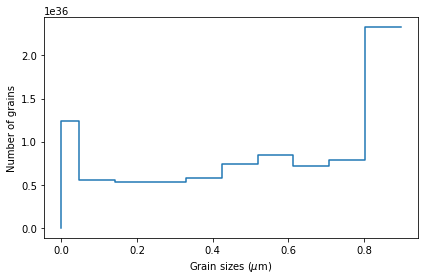

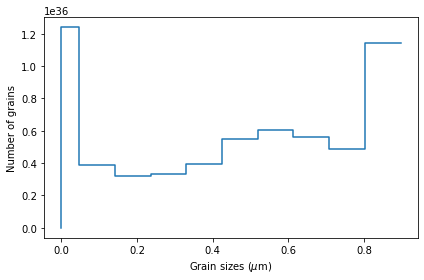

In [4]:
import analyze_co5bold_functions as a5d
fig, ax = a5d.plot_grainsize_distribution(
    dustdensity_path='../r3dresults/st28gm06n052/186/dust_density_dust.inp',
    grainsizes_path= '../grain_sizes_binned_186.dat'
)
fig.show()
fig, ax = a5d.plot_grainsize_distribution(
    dustdensity_path='../r3dresults/st28gm06n052/190/dust_density_dust.inp',
    grainsizes_path= '../grain_sizes_binned_190.dat'
)
fig.show()
fig, ax = a5d.plot_grainsize_distribution(
    dustdensity_path='../r3dresults/st28gm06n052/198/dust_density_dust.inp',
    grainsizes_path= '../grain_sizes_binned_198.dat'
)
fig.show()

In [1]:
import analyze_co5bold_functions as a5d
a5d.extract_grainsizes(
    amrpath='../r3dresults/st28gm06n052_hires/amr_grid.inp',
    gridpath='../r3dresults/st28gm06n052_hires/grid_distances.csv',
    sizepath='../r3dresults/st28gm06n052_hires/grid_cellsizes.csv',
)

import analyze_r3d_functions as a3d
grainsizes,Nleafs = a3d.load_grainsizes()

plt.plot(grainsizes,'.',markersize=1)
plt.hist(grainsizes)

Loading R3D grid
Loading C5D grid properties


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Computing grain sizes and saving them in R3D-grid (186)
Loading gas and monomer densities from CO5BOLD-files (186)
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
C5D grain sizes:
    grain_sizes_186.dat
DONE



NameError: name 'plt' is not defined

In [11]:
import numpy as np

np.min(grainsizes[np.where(grainsizes > 0)[0]])



1.2803122233974629e-09

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11367/2374491231.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


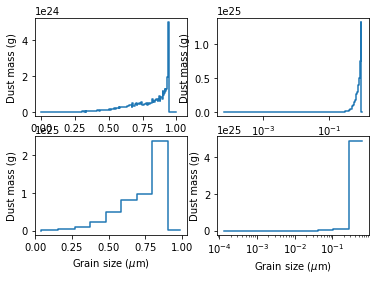

In [1]:
import analyze_co5bold_functions as a5d
fig,ax = a5d.plot_grainsizemass_distribution(phase='186')
fig.show()


Extracting species mg2sio4_0.04725050785375921
3
Extracting species mg2sio4_0.14162608092169926
3
Extracting species mg2sio4_0.23600165398963932
3
Extracting species mg2sio4_0.3303772270575793
3
Extracting species mg2sio4_0.4247528001255193
3
Extracting species mg2sio4_0.5191283731934594
3
Extracting species mg2sio4_0.6135039462613995
3
Extracting species mg2sio4_0.7078795193293396
3
Extracting species mg2sio4_0.8022550923972795
3
Extracting species mg2sio4_0.8966306654652195
3


/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:1314: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
/tmp/ipykernel_37881/1347049393.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  a3d.plot_allkappa(


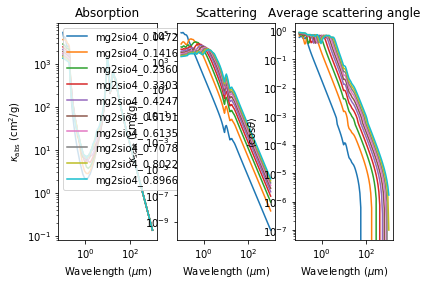

In [1]:
import analyze_r3d_functions as a3d
a3d.plot_allkappa(
    path='/home/joachim/program/optool/testfolder/log_test/'
).show()

In [1]:
import create_r3d_functions as c3d

c3d.create_optoolscript(
    wavelength_path='../r3dresults/st28gm06n052/wavelength_micron.inp',
    grainum_sizes='../grain_sizes_binned_186.dat',
    grainsize_type='lognormal'
)


Extracting grain sizes from ../grain_sizes_binned_186.dat
    Grain sizes are (um):
[0.04725051 0.14162608 0.23600165 0.33037723 0.4247528  0.51912837
 0.61350395 0.70787952 0.80225509 0.89663067]
    Grain size ranges are then
0.023625253926879607 - 0.04725050785375921 - 0.09443829438772924
0.09443829438772924 - 0.14162608092169926 - 0.1888138674556693
0.1888138674556693 - 0.23600165398963932 - 0.28318944052360934
0.28318944052360934 - 0.3303772270575793 - 0.3775650135915493
0.3775650135915493 - 0.4247528001255193 - 0.47194058665948935
0.47194058665948935 - 0.5191283731934594 - 0.5663161597274294
0.5663161597274294 - 0.6135039462613995 - 0.6606917327953695
0.6606917327953695 - 0.7078795193293396 - 0.7550673058633095
0.7550673058633095 - 0.8022550923972795 - 0.8494428789312496
0.8494428789312496 - 0.8966306654652195 - 0.9438184519991895
create_optoolscript:
    ../optool_script.sh
DONE



In [6]:
import analyze_co5bold_functions as a5d

a5d.bin_grainsizes(
    grainsizepath='../grain_sizes_186.dat',
    phase='186',
    nbins=10,
    lin='y'
)


a5d.bin_grainsizes():
    grain_sizes_binned_186.dat
DONE



In [4]:
# TODO
# use BHMIe code to create kappas from c5d-grainsizes
import analyze_r3d_functions as a3d
import create_r3d_functions as c3d
import numpy as np

# extract list of grainsizes and save in list
grainsizes,Nleafs = a3d.load_grainsizes(
    grainsize_path='../grain_sizes_binned_186.dat'
)

# Extract an array with the grain sizes only
grainum_sizes = np.unique(grainsizes[np.where(grainsizes > 0)[0]])
# Change unit to um
grainum_sizes *= 1e4

print(f'Grain sizes are {grainum_sizes} um')

# what's the density used for the optool-data?

c3d.create_kappaabs(
    wavelengthpath='../r3dresults/st28gm06n052/wavelength_micron.inp',
    optconstlist=['mg2sio4'],
    agrainlist=grainum_sizes,
    matdens=5
)


Grain sizes are [0.04725051 0.14162608 0.23600165 0.33037723 0.4247528  0.51912837
 0.61350395 0.70787952 0.80225509 0.89663067] um
Doing wavelength  1.000000e-05 cm
...Doing grain size  3.610655e-06 cm
...Doing grain size  3.714350e-06 cm
...Doing grain size  3.821024e-06 cm
...Doing grain size  3.930761e-06 cm
...Doing grain size  4.043650e-06 cm
...Doing grain size  4.159781e-06 cm
...Doing grain size  4.279247e-06 cm
...Doing grain size  4.402144e-06 cm
...Doing grain size  4.528571e-06 cm
...Doing grain size  4.658628e-06 cm
...Doing grain size  4.792421e-06 cm
...Doing grain size  4.930056e-06 cm
...Doing grain size  5.071644e-06 cm
...Doing grain size  5.217298e-06 cm
...Doing grain size  5.367135e-06 cm
...Doing grain size  5.521275e-06 cm
...Doing grain size  5.679843e-06 cm
...Doing grain size  5.842964e-06 cm
...Doing grain size  6.010770e-06 cm
...Doing grain size  6.183395e-06 cm
Doing wavelength  1.097499e-05 cm
...Doing grain size  3.610655e-06 cm
...Doing grain size  3.

In [5]:
import analyze_co5bold_functions  as a5d

a5d.extract_grainsizes(
    amrpath='../r3dresults/st28gm06n052_hires/amr_grid.inp',
    gridpath='../r3dresults/st28gm06n052_hires/grid_distances.csv',
    sizepath='../r3dresults/st28gm06n052_hires/grid_cellsizes.csv',
    savpath='../co5bold_data/dst28gm06n052/st28gm06n052_186.sav',
)
# 49 min


Loading R3D grid
Loading C5D grid properties


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Computing grain sizes and saving them in R3D-grid (186)
Loading gas and monomer densities from CO5BOLD-files (186)
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
C5D grain sizes:
    grain_sizes_186.dat
DONE



In [1]:
import analyze_co5bold_functions as a5d

a5d.bin_grainsizes(
    grainsizepath='../grain_sizes_186.dat',
    phase=186,
    nbins=10,
    lin='y'
)


a5d.bin_grainsizes():
    grain_sizes_binned_186.dat
DONE



In [1]:
import create_r3d_functions as c3d

c3d.create_optoolscript(
    wavelength_path=f'../r3dresults/st28gm06n052_hires/wavelength_micron.inp',
    phase=186,
    grainum_sizes=f'../grain_sizes_binned_186.dat',
    grainsize_type='normal',
    grainsize_na=21,
    specie='mg2sio4',
    grain_type='mie'
)


Extracting grain sizes from ../grain_sizes_binned_186.dat
    Grain sizes are (um):
[0.0472 0.1416 0.236  0.3303 0.4247 0.5191 0.6135 0.7079 0.8022 0.8966]
    Grain size ranges are then
4.720e-03 - 4.720e-02 - 9.440e-02
9.440e-02 - 1.416e-01 - 1.888e-01
1.888e-01 - 2.360e-01 - 2.832e-01
2.832e-01 - 3.303e-01 - 3.775e-01
3.775e-01 - 4.247e-01 - 4.719e-01
4.719e-01 - 5.191e-01 - 5.663e-01
5.663e-01 - 6.135e-01 - 6.607e-01
6.607e-01 - 7.079e-01 - 7.550e-01
7.550e-01 - 8.022e-01 - 8.494e-01
8.494e-01 - 8.966e-01 - 9.438e-01
create_optoolscript:
    ../optool_script.sh
DONE



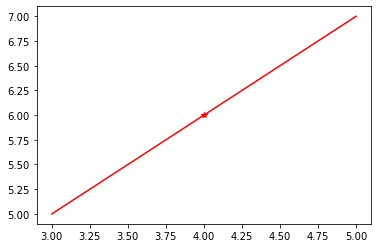

In [13]:
import matplotlib.pyplot as plt

plt.plot([3,5],[5,7],color='r')


plt.plot(4,6,marker='*',color='r')




In [36]:
from matplotlib.lines import Line2D
markerlist = list(Line2D.markers)

for nn in range(10):
    print(markerlist[2*nn])


.
o
^
>
2
4
s
*
H
x


In [25]:
import matplotlib.colors as mcolors

for colour in list(mcolors.TABLEAU_COLORS):
    print(colour.split(':')[1])




blue
orange
green
red
purple
brown
pink
gray
olive
cyan


In [34]:
teststring = 'mg2sio4_4.720e-02'

divider = 10**(1 + -1*int(teststring.split('_')[1].split('e')[1]))

print(  round(float(teststring.split('_')[1].split('e')[0])*100)/divider  )


0.472


In [2]:
# Just create a star-kappaabs-file

import analyze_r3d_functions as a3d
import analyze_co5bold_functions as a5d

wavelengths,Nwave = a3d.load_wavelengthgrid(path='../r3dresults/opacities_st28gm06n052/wavelength_micron.inp')
#wavelengths = np.array(wavelengths)


with open(f'../dustkappa_opastar.inp', 'w') as fopac:

    # Write header (1 for no scattering in this and number of wavelengths)
    fopac.write(f'1\n{Nwave}\n')

    # Write wavelength, abscoeff, scattercoeff
    for nn,wave in enumerate(wavelengths):
        fopac.write(f'{wave}    1.0    0.0\n')


In [1]:
import create_r3d_functions as c3d

c3d.create_optoolscript(
    wavelength_path=f'../r3dresults/opacities_st28gm06n052/wavelength_micron.inp',
    phase=186,
    grainum_sizes=f'../grain_sizes_binned_186.dat',
    grainsize_type='normal',
    grainsize_na=21,
    specie='mg2sio4',
    grain_type='mie'
)


Extracting grain sizes from ../grain_sizes_binned_186.dat
    Grain sizes are (um):
[0.0472 0.1416 0.236  0.3303 0.4247 0.5191 0.6135 0.7079 0.8022 0.8966]
create_optoolscript:
    ../optool_script.sh
    ../dustopac_{specie}_{phase}.inp
DONE



6977.219326274044

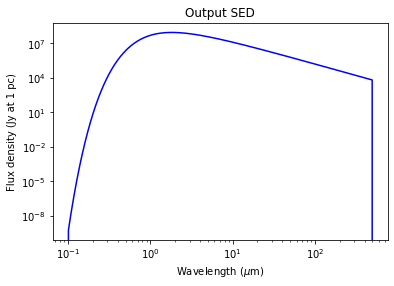

In [9]:
import analyze_r3d_functions as a3d

a3d.plot_sed(path='../tillrackham/st28gm06n052_pointsource/test/spectrum.out')
a3d.compute_sed_luminosity(
    path='../tillrackham/st28gm06n052_pointsource/test/spectrum.out',
    distance=1
)/3.828e26



## Plot temperatures

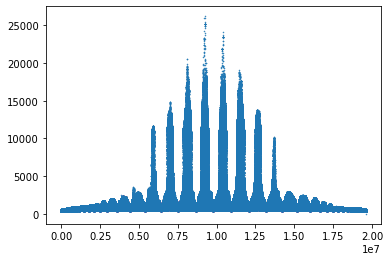

In [2]:
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

# Load c5d-temperature
Ncells, Nspecies, temperatures = a3d.load_temperature(
    path='../r3dresults/st28gm06n052_staranddust/186/dust_temperature.dat',
    numb_specie=1
)

# Or R3D-temperature, _pointtemperature


plt.plot(temperatures,'.',markersize=1)
# takes 1,5min


In [3]:
import analyze_co5bold_functions as a5d
AUcm = 1.49598e13
# Load stellar radius (for plots)

Mstar,Rstar,Lstar = a5d.load_star_information(
    savpath='../co5bold_data/dst28gm06n052/st28gm06n052_186.sav',
    printoutput='n'
)
Rstar /= AUcm
print(Rstar)

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


1.6504398454524793


In [4]:
# Load radial and xyz-coords of cells

cellcoords = a3d.load_griddistances(
    gridpath='../r3dresults/st28gm06n052_staranddust/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n052_staranddust/amr_grid.inp'
)
radii = cellcoords[:,0]/AUcm
# takes 1min

(0, 4000)

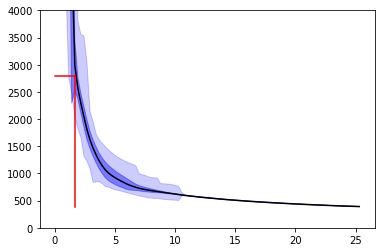

In [9]:
import numpy as np

# set up radial bins, loop through, save mean of all temperatures in these bins

Nbins = 100
radial_bins = np.linspace(0,radii.max(),Nbins+1)
radial_range = np.zeros(Nbins)
temperature_bins = np.zeros(Nbins)
temperature_max = np.zeros(Nbins)
temperature_min = np.zeros(Nbins)
temperature_std = np.zeros(Nbins)

# Make a radial-vector also


for nn in range(Nbins):
    ncells = np.where((radii >= radial_bins[nn]) & (radii < radial_bins[nn+1]))[0]
    temperature_bins[nn] = temperatures[ncells].mean()
    temperature_max[nn] = temperatures[ncells].max()
    temperature_min[nn] = temperatures[ncells].min()
    temperature_std[nn] = temperatures[ncells].std()
    radial_range[nn] = radial_bins[nn] + 0.5 * radial_bins[1]




plt.plot(radial_range,temperature_bins,'k')

# Deviation (ie 3D-effects)

# Add some shaded area beneath instead? (it looks better)

plt.fill_between(
    radial_range,
    temperature_min,
    temperature_max,
    color='b',
    alpha=0.2
)

plt.fill_between(
    radial_range,
    temperature_bins-temperature_std,
    temperature_bins+temperature_std,
    color='b',
    alpha=0.4
)



plt.plot([Rstar,Rstar],[temperature_bins[-1],2800],'r')
plt.plot([0,Rstar],[2800,2800],'r')
plt.ylim(0,4000)

# load cellcoordinates, save temperatures along each axis, x,y,z, 
# and plot (in both directions)

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")
/tmp/ipykernel_21745/508430398.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


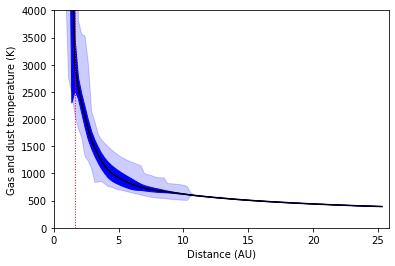

In [1]:
import analyze_r3d_functions as a3d
fig,ax = a3d.plot_temperaturebins_radius(
    temperature_path='../r3dresults/st28gm06n052_staranddust/186/dust_temperature.dat',
    grid_path='../r3dresults/st28gm06n052_staranddust/grid_distances.csv',
    amr_path='../r3dresults/st28gm06n052_staranddust/amr_grid.inp',
    numb_specie=1
)
fig.show()

0

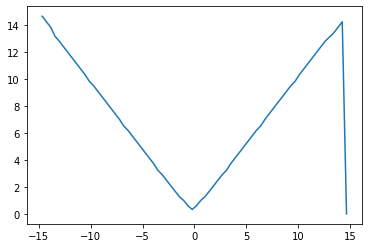

In [30]:
# X : cellcoords[:,1]
# Y : cellcoords[:,2]
# Z : cellcoords[:,3]

# Needs grid_distnaces.csv and grid_cellsizes.csv
import numpy as np
import matplotlib.pyplot as plt
import os 

# Load cellsizes for linear plots
# and grid_cellsizes.csv

cellsizes = a3d.load_cellsizes(
    sizepath='../r3dresults/st28gm06n052_staranddust/grid_cellsizes.csv',
    amrpath='../r3dresults/st28gm06n052_staranddust/amr_grid.inp'
)

cellsizemax = cellsizes.max()
Ncells = cellsizes.size



# binna från Xmin till Xmax
linearmax = (cellcoords[:,1].max() + cellcoords[:,2].max() + cellcoords[:,3].max())/3

# Nbins should be same as N base cells, which is stated in amr_grid
# does amr_:grid-loader load this? check this
Nbins = 72



linear_bins = np.linspace(-linearmax,linearmax,Nbins)
linear_temperature = np.zeros((Nbins,3))

# Multiply tolerance to max cell size
#cellsizemax *= 2



# koordinaterna för varje cell ska vara inom +/- cellsizemax
# och inom linear_bins[nn] och linear_bins[nn+1]


# för X-endast


testradial = np.zeros(Nbins)


for nn in range(Nbins-1):
    
    # X-axis data
    ncells = np.where(
        ((cellcoords[:,2] >= -cellsizemax) & (cellcoords[:,2] < cellsizemax)) & \
        ((cellcoords[:,3] >= -cellsizemax) & (cellcoords[:,3] < cellsizemax)) & \
        ((cellcoords[:,1] >= linear_bins[nn]) & (cellcoords[:,1] < linear_bins[nn+1]))
    )[0]

    if ncells.size > 0:
        testradial[nn] = cellcoords[ncells,0].sum()/ncells.size
    #    linear_temperature[nn,nc-1] = temperatures[ncells].sum()/ncells.size




plt.plot(linear_bins/AUcm,testradial/AUcm)



#if ncells.size > 0:


#plt.plot(linear_bins/AUcm,linear_temperature)
#plt.plot([-Rstar,Rstar],[2800,2800],'r')
#plt.plot([Rstar,Rstar],[0,2800],'r')
#plt.plot([-Rstar,-Rstar],[0,2800],'r')


# HÄR ÄR JAG




/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


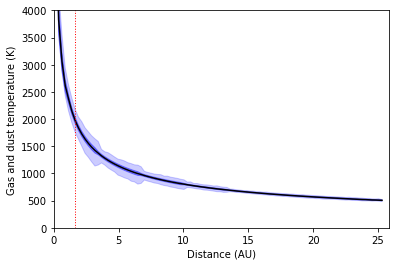

In [3]:
import analyze_r3d_functions as a3d

fig,ax, T,Tstd,Tminmax,radius = a3d.plot_temperaturebins_radius(
    temperature_path='../r3dsims/pointssource_emptytest/dust_temperature.dat',
    grid_path='../r3dsims/grid_distances.csv',
    amr_path='../r3dsims/amr_grid.inp',
    numb_specie = 1
)
fig.show()
# T at 1.65 AU is more 2000 K
# 2800K at 0.7 AU, 

luminosity = a3d.compute_sed_luminosity('../r3dsims/pointssource_emptytest/spectrum.out')
print(luminosity/3.8280e33)
# Should be around 7000Lsol



/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")
/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:1243: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig, ax = plt.figure('Average radial temperatures', figsize=(6, 4)), plt.axes()
/tmp/ipykernel_24319/1480476502.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_24319/1480476502.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the 

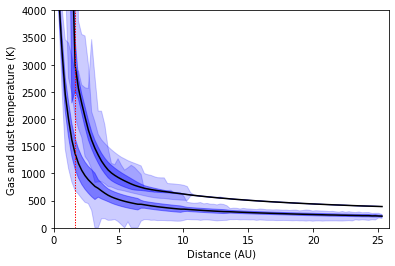

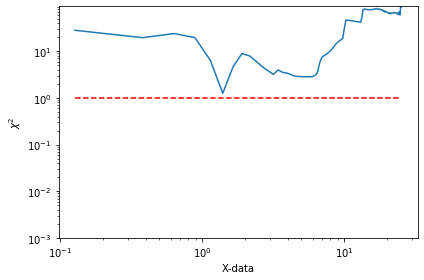

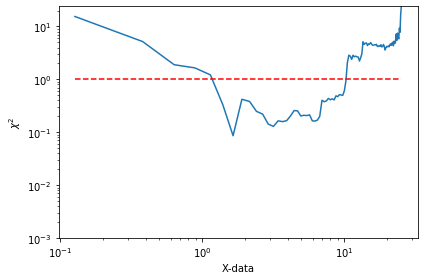

In [1]:
# Plot chi2-comparison of temperatures - co5bold vs point source temperature

import analyze_r3d_functions as a3d



# Load cobold-T
fig,ax, T_c5d,Tstd_c5d,Tminmax_c5d,radius_c5d = a3d.plot_temperaturebins_radius(
    temperature_path='../r3dresults/st28gm06n052_staranddust/186/dust_temperature.dat',
    grid_path='../r3dresults/st28gm06n052_staranddust/grid_distances.csv',
    amr_path='../r3dresults/st28gm06n052_staranddust/amr_grid.inp',
    numb_specie = 1
)

# Load r3d-T
fig,ax, T_r3d,Tstd_r3d,Tminmax_r3d,radius_r3d = a3d.plot_temperaturebins_radius(
    temperature_path='../r3dresults/st28gm06n052_pointtemperature/186/dust_temperature.dat',
    grid_path='../r3dresults/st28gm06n052_pointtemperature/grid_distances.csv',
    amr_path='../r3dresults/st28gm06n052_pointtemperature/amr_grid.inp',
    numb_specie = 1
)

# Compute and plot chi2
Tsigma = Tstd_c5d + Tstd_r3d
Tminmax = Tminmax_c5d + Tminmax_r3d

# With std
fig,ax,c2,c2red = a3d.plot_chisquare(
    T_c5d,T_r3d,Tsigma,radius_c5d
)
fig.show()

# with minmax
fig,ax,c2,c2red = a3d.plot_chisquare(
    T_c5d,T_r3d,Tminmax,radius_c5d
)
fig.show()





/tmp/ipykernel_16943/3471957114.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


"\n# 2 put data in a list of data (inputs )\nif type(sed1) == list:\n    sed1 = np.array(sed1)\nif type(sed2) == list:\n    sed2 = np.array(sed2)\n\n\n# 3\n#     chi2 = 1/N * sum(modell2 - modell1)^2/(0.1*modell1)^2\n\nchisquare = (sed2 - sed1)**2 / (0.1*sed1)**2\n\nchisquarereduced = 1/sed1.size * np.sum(chisquare)\n\nprint(chisquarereduced)\n\n\n\nplt.figure(1)\nplt.plot(wavelength1,sed1,'b')\nplt.plot(wavelength2,sed2,'r')\nplt.yscale('log')\nplt.xscale('log')\n\n\nplt.figure(2)\nplt.plot(wavelength1,chisquare)\nplt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')\nplt.yscale('log')\nplt.xscale('log')\nplt.ylim(1e-2,chisquare.max());\n\nplt.figure(3)\nplt.plot(wavelength1,chisquare)\nplt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')\nplt.xscale('log')\nplt.ylim(0,100);\n\nplt.figure(4)\nplt.plot(wavelength1,chisquare)\nplt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')\nplt.xscale('log')\nplt.ylim(0,10);\n"

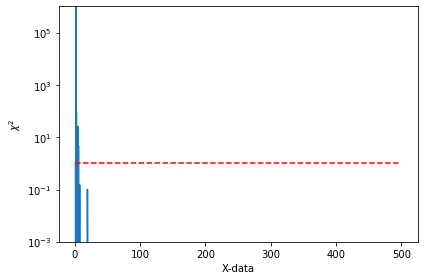

In [1]:
# Space to test function to plot chi2-tests

import analyze_r3d_functions as a3d

import numpy as np
import matplotlib.pyplot as plt

# 1 load some testdata, eg SEDs

wavelength1, sed1 = a3d.load_spectrum(
    path='../r3dresults/st28gm06n052_staranddust/186/spectrum_i000_phi000.out'
)

wavelength2, sed2 = a3d.load_spectrum(
    path='../r3dresults/st28gm06n052_staranddust-rerun/186/spectrum_i000_phi000.out'
)
sed2 = np.array(sed2)


fig,ax,c2,c2red = a3d.plot_chisquare(
    sed1,sed2,0.1*sed2,wavelength1
)

fig.show()





"""
# 2 put data in a list of data (inputs )
if type(sed1) == list:
    sed1 = np.array(sed1)
if type(sed2) == list:
    sed2 = np.array(sed2)


# 3
#     chi2 = 1/N * sum(modell2 - modell1)^2/(0.1*modell1)^2

chisquare = (sed2 - sed1)**2 / (0.1*sed1)**2

chisquarereduced = 1/sed1.size * np.sum(chisquare)

print(chisquarereduced)



plt.figure(1)
plt.plot(wavelength1,sed1,'b')
plt.plot(wavelength2,sed2,'r')
plt.yscale('log')
plt.xscale('log')


plt.figure(2)
plt.plot(wavelength1,chisquare)
plt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-2,chisquare.max());

plt.figure(3)
plt.plot(wavelength1,chisquare)
plt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')
plt.xscale('log')
plt.ylim(0,100);

plt.figure(4)
plt.plot(wavelength1,chisquare)
plt.plot([wavelength1[0],wavelength1[-1]],[1,1],'k:')
plt.xscale('log')
plt.ylim(0,10);
"""

In [1]:
import analyze_r3d_functions as a3d

Reffective,fig,ax = a3d.plot_opticalthick(
    path='../r3dsims/darwinstar_testsims/'
)


print(f'{Reffective / 1.49598e13} AU')

Extracting species number 1: opastar


In [8]:
# Compare darwin-and-cobold-stars

import create_r3d_functions as c3d
c3d.merge_dustdensities(
    filenames=['dust_density_cobold.inp','dust_density_darwin.inp'],
    modelname='../r3dsims/',
    phases=['temp']
)


Merging 2 dust_density_*.inp files for phase temp
merge_dustdensities:
    ../r3dresults/../r3dsims//temp/dust_density.inp
DONE



/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:986: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:1006: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:1026: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


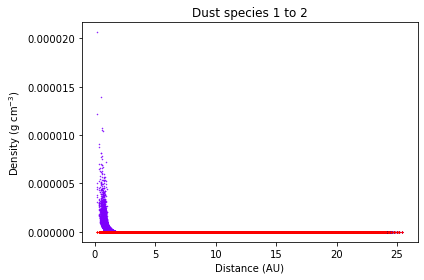

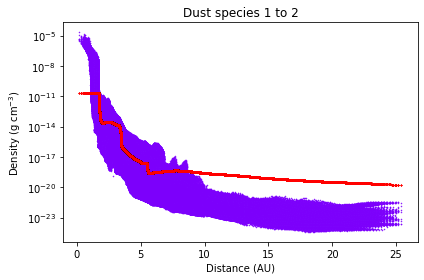

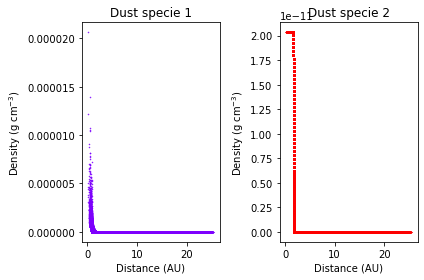

In [1]:
import analyze_r3d_functions as a3d

a3d.plot_alldensity_radius(
    path='../r3dsims/temp/'
)




/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:730: RuntimeWarning: divide by zero encountered in log10
  image2dlog[nx,ny] = np.log10(flux * 1.e23 * 2.35044305391e-11 * pixelsize_mas**2)


TypeError: unsupported operand type(s) for /: 'list' and 'float'

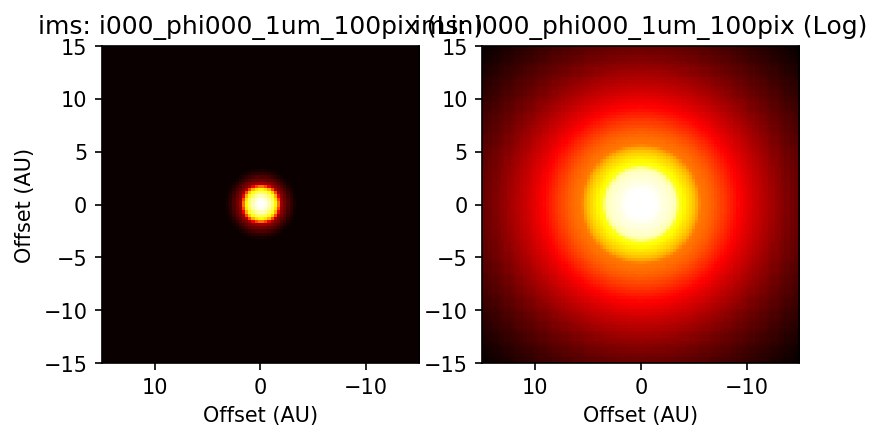

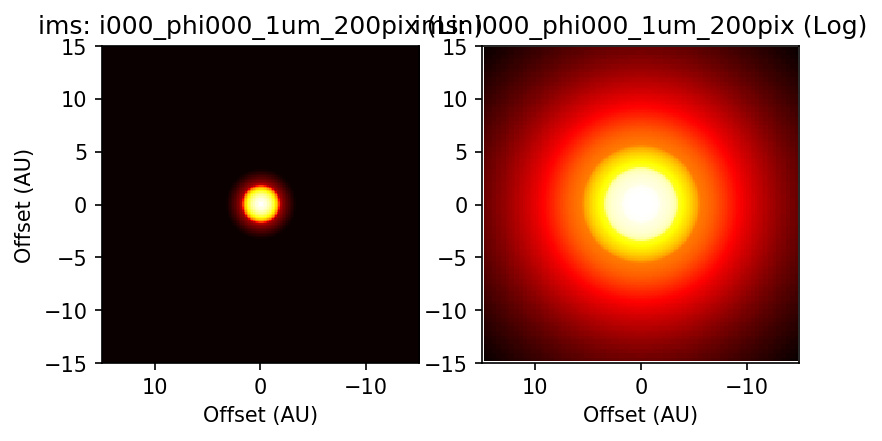

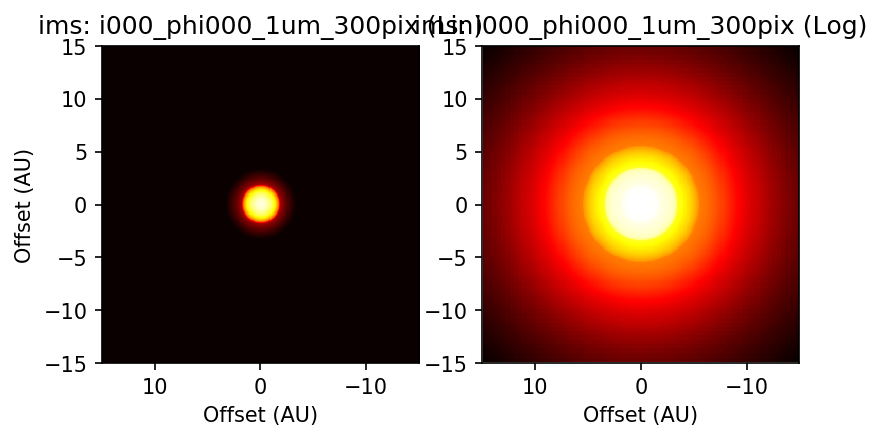

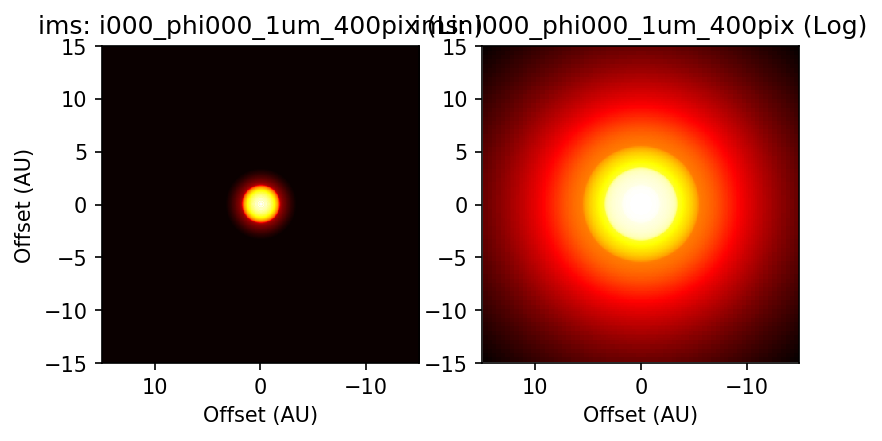

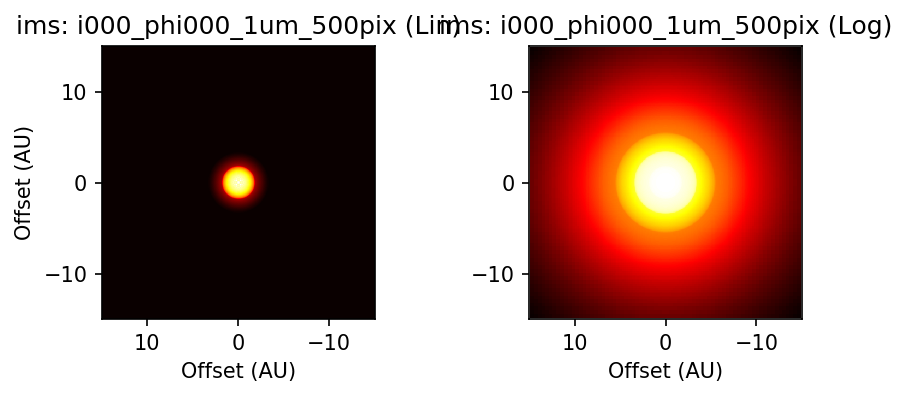

In [5]:
# flux of darwin-star-images vs resolution
import analyze_r3d_functions as a3d

fig,ax,fluxtotal = a3d.plot_images(
    path='../r3dsims/darwinstar_testsims/',
    images=[
        'image_i000_phi000_1um_100pix.out',
        'image_i000_phi000_1um_200pix.out',
        'image_i000_phi000_1um_300pix.out',
        'image_i000_phi000_1um_400pix.out',
        'image_i000_phi000_1um_500pix.out'
    ]
)

for flux in fluxtotal:
    print(flux/1e6) # in MJy

